# Imports

In [1]:
import pandas as pd # dataframes
from sklearn.preprocessing import RobustScaler # scale to zero mean and unit variance
from sklearn.ensemble import IsolationForest # anomaly detection
from sklearn.decomposition import PCA # primary component analysis
import matplotlib.pyplot as plt # plots
import seaborn as sns # advanced plots
import numpy as np # ndarrays
from scipy import stats # z-score

# Background
## Principal Component Analysis
Principal component analysis (PCA) is technique used to decrease dimensionality of data in statistics and machine-learning. In the process, it tries to maintain the original variability as best as possible.

A PCA:
1. Requires **normally-distributed numerical** data.
2. Utilizes feature correlations and is therefore **sensitive to outliers and feature scales**. Features should therefore be standardized to zero mean and unit variance.

# Preprocess the Data

## Reading The Data

In [2]:
data = pd.read_csv('./data/hcvdat11_Anomaly.csv')

## Missing Data
Are there missing values in the dataset?

In [3]:
data.isnull().values.any()

False

In [4]:
data.isna().values.any()

False

## Inspecting The Dataframe

In [5]:
data.head(4)

,Unnamed: 0,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7


## Dropping Columns
Drop the malformatted index-column at the beginning.

In [6]:
data.drop(columns=['Unnamed: 0'], inplace=True)

Principal Component Analysis (PCA) does not work well with categorical variables.

One-Hot-Encoding could enable PCA for e.g. binary variables but could also introduce errors.

Therefore, drop the column 'Sex':

In [7]:
data.drop(columns=['Sex'], inplace=True)
data.head(4)

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7


## Analyze Feature Distributions

In [8]:
def plot_feature_distribution(df: pd.DataFrame, n_rows: int, n_cols: int, figsize: tuple[float, float], suptitle: str) -> None:
    """ Plots a histplot including distribution for each column of a given dataframe

    Disables additional subplots

    Args:
        df (pd.DataFrame): the dataframe containing the columns of interest
        n_rows (int): number of rows for plt.subplots
        n_cols (int): number of columns for plt.subplots
        figsize (tuple[float, float]): (width, height) of each figure 
        suptitle (str): title above all subplots; argument for plt.suptitle()

    Returns:
        None: Renders the plot without returning a value
    """
    # create subplots based on the function arguments
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize, constrained_layout=True, sharey=False)

    # plot each col onto one ax
    for col, ax in zip(df.columns, axes.flat):
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(col)


    # boxplot in last axis
    last_axis = axes.flat[-1]
    sns.boxplot(data=df, ax=last_axis)
    last_axis.set_title('Dataset Variability')
    plt.xticks(rotation=90)
    
    # disable leftover axes
    #for ax in axes.flat[df.columns.size:]:
    #    ax.set_axis_off()
    
    # above all subplots
    plt.suptitle(suptitle)


    # render the plots
    plt.show()

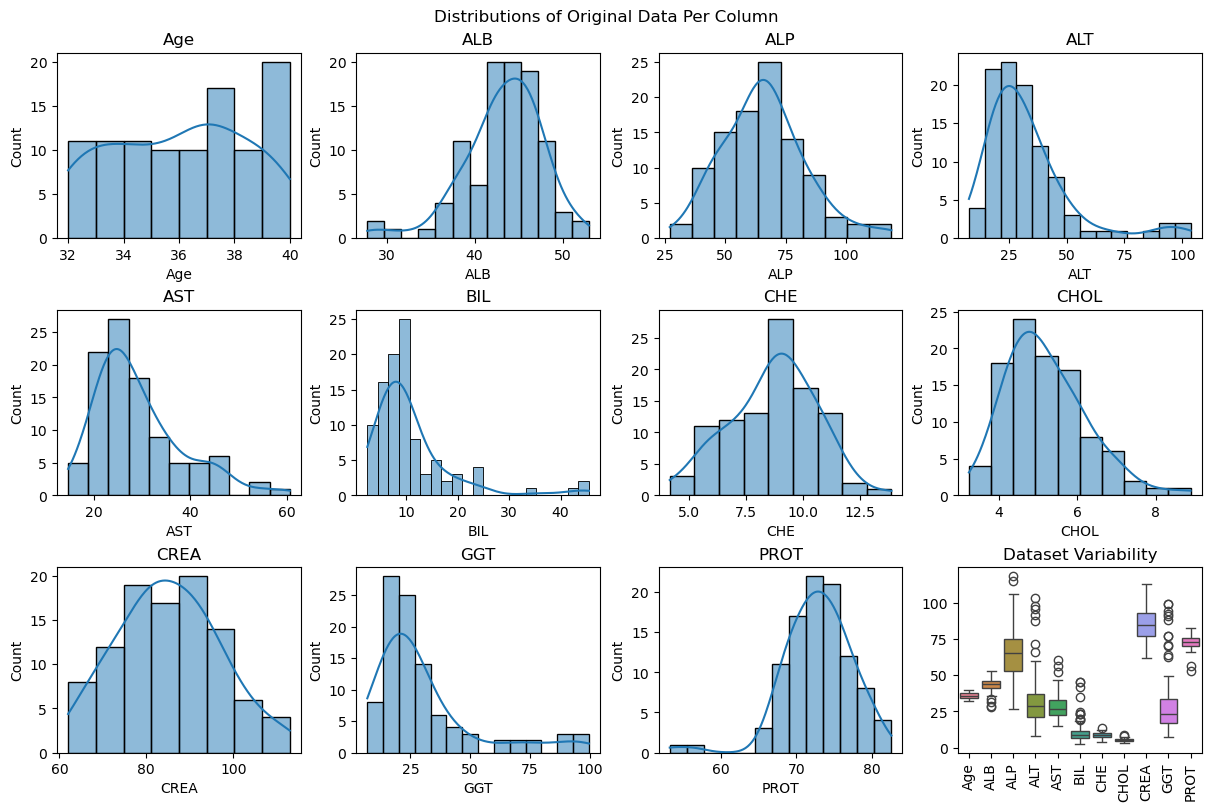

In [9]:
# TODO: Make interactive using plotly subplots
plot_feature_distribution(df=data, n_rows=3, n_cols=4, figsize=(12,8), suptitle='Distributions of Original Data per Column')

### Discussion
Most features (ALB, ALT, AST, BIL, CHOL, GGT and PROT) roughly follow normal distributions with outliers. KREA, CHE and ALP are normally distributed without outliers. Age alone is not normally distributed. Therefore, after standardization to control for outliers, the data is suitable for pca.

## Standardize Features
Standardize the features to zero mean and unit variance using a robust scaling approach to control for the effect of outliers and different scales:

In [10]:
scaler = RobustScaler() # instantiate scaler
data_scaled_np = scaler.fit_transform(data) # fit the scaler create scaled data
data_scaled = pd.DataFrame(data_scaled_np, columns=data.columns) # transform ndarray to DataFrame

Inspect the scaled features:

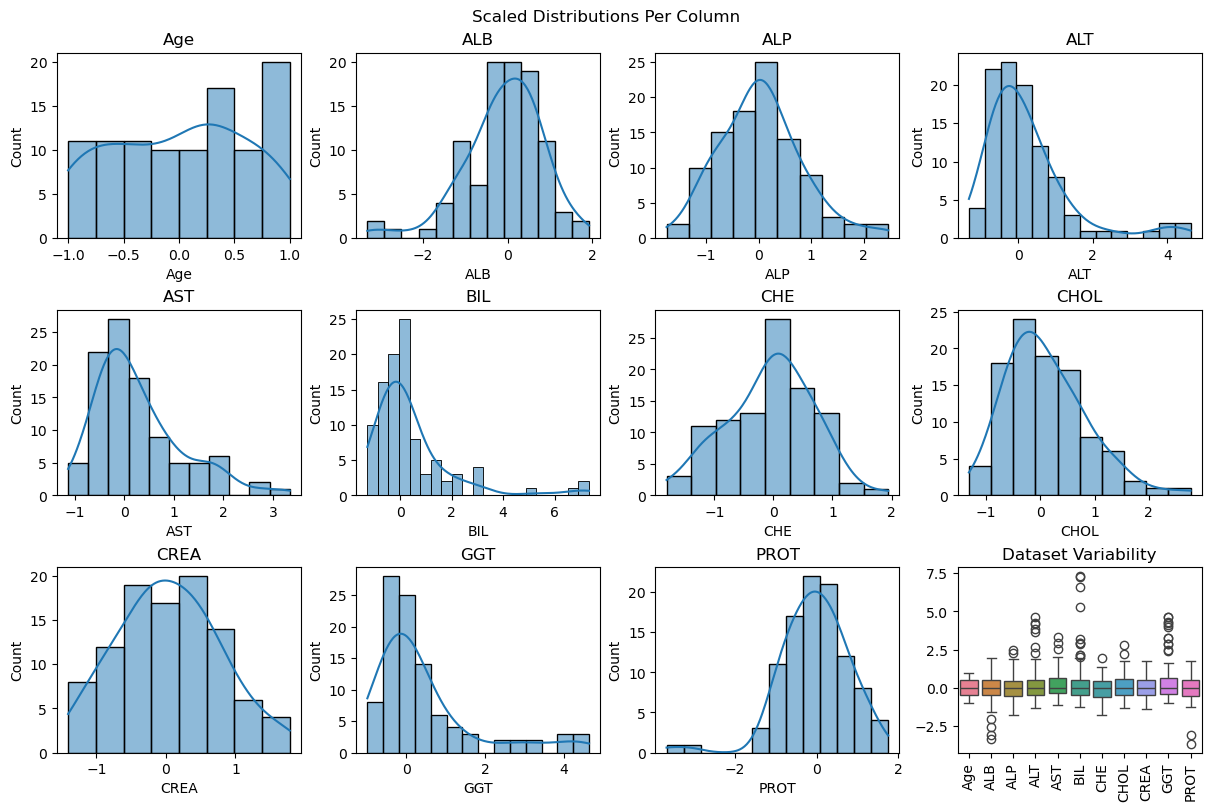

In [11]:
plot_feature_distribution(df=data_scaled, n_rows=3, n_cols=4, figsize=(12,8), suptitle='Scaled Distributions per Column')

### Discussion
All features have a mean of zero and similar scales.

# Perform A PCA
Q: Would it make sense to use a reduced number of Principal Components instead of the original features?

A: Yes, the very purpose of principal component analysis is to reduce the number of dimensions in data. This is usually desired to make data more computationally effective and easier to interpret for humans.

In [12]:
# set the number of principal components here
N_COMPONENTS = len(data.columns) - 1

pca = PCA(n_components=N_COMPONENTS)

In [13]:
# create principal components using the scaled data
data_pca = pca.fit_transform(X=data_scaled)
data_pca = pd.DataFrame(data_pca)

Principal components are sorted by the degree to which they explain the target's variance (highest to lowest).

Therefore plot the first two primary components:

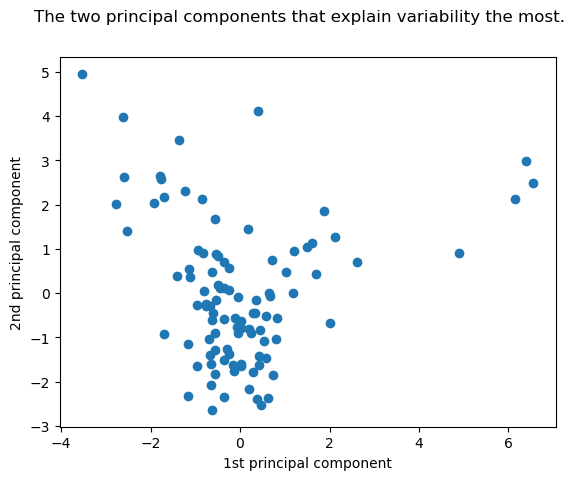

In [14]:
plt.scatter(data_pca[0], data_pca[1])
plt.xlabel(f'1st principal component')
plt.ylabel(f'2nd principal component')
plt.suptitle('The two principal components that explain variability the most.')
plt.show()

## Scree Plot
We can analyze the influence of single principal components on the explained variance ratio using so-called scree plots. 

- Single explained variance ratios of the principal components are already included as attributes in a fitted pca:

In [15]:
# display the explained variance ratio of the principal components
pd.DataFrame(pca.explained_variance_ratio_).transpose()

,0,1,2,3,4,5,6,7,8,9
0,0.248848,0.242166,0.135041,0.104322,0.059442,0.052222,0.047394,0.035416,0.034154,0.022579


- Cumulative variance ratios need to be calculated

In [16]:
# calculate cumulative explained ratios for plotting
cumulative_explained_ratio = []

# loop over each principal component's explained variance ratio
for index, value in enumerate(pca.explained_variance_ratio_):
    if len(cumulative_explained_ratio) == 0:
        # save the first value as is
        cumulative_explained_ratio.append(value)
    else:
        # add subsequent values to their predecessor and save
        cumulative_explained_ratio.append(value + cumulative_explained_ratio[index -1])

Now plot the single and cumulative explained ratios

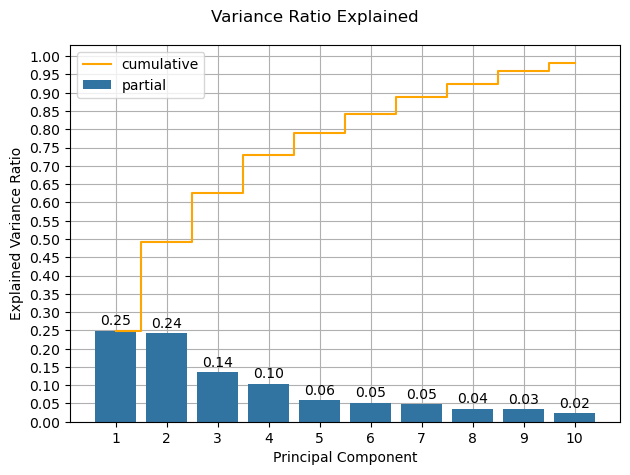

In [17]:
# enable stacked plots by using the same axis
fig, ax = plt.subplots()

# plots
barplot = sns.barplot(pca.explained_variance_ratio_, ax=ax, label='partial')
lineplot = sns.lineplot(cumulative_explained_ratio ,ax=ax, drawstyle='steps-mid', color='orange', label='cumulative')

# labels
ax.set_ylabel('Explained Variance Ratio')
ax.set_xlabel('Principal Component')

# grid
ax.grid()
ax.set_axisbelow(True)

# legend
plt.legend()

# axes
plt.yticks(np.linspace(0, 1, 21)) # steps of five on y-axis
plt.xticks(range(0,10)) # start counting from one
ax.set(xticklabels=range(1,11,1)) # " "

# heading
plt.suptitle('Variance Ratio Explained')

# display the values
barplot.bar_label(ax.containers[0], fmt='{0:.2f}', padding=2)

# settings
plt.tight_layout()

plt.show()

### Discussion
The scree plot shows us how much variance ratio each principal component explains, and how many principal components we need to explain the variance to a certain degree. 

Here, singular principal components do not contribute strongly to the explanation. To explain at least 95 %, at least 9 principal components are necessary.

In [18]:
# TODO: Include Loading Plot

# Build an Anomaly Detection Model
From the [scikit-learn documentation](https://scikit-learn.org/stable/modules/outlier_detection.html) we learn, that the two algorithms isolation forest and local outlier factor score the best for outlier detection.

Use the Isolation Forest here because it provides decision boundaries.

In [19]:
# TODO: Tweak parameters so that not all instances are categorized the same way
clf = IsolationForest(max_samples=10, contamination=0.1, bootstrap=True, random_state=42)